## GA evoltion of synaptic weights for a generalized cerebellar model

Using a general network with anatomical properties of the cerebellar model and the OKN eye plant model, use a GA to tunned the weights of synaptic connections to match the prediction properties (initiation and terminnation) observed in VOR adaptation.

# Eye plant with direct and indirect paths

Model presented at Hirata et al. 2002 Annals of the New York Academy of Sciences. Inagaki at al 2007.

$$G^{visual}_{indirect}(s)=\frac{0.025s^2 + 1.25s + 0.552885}{0.20643s^2+1.3544s+0.6589}e^{-0.047s}$$
$$G^{visual}_{direct}(s)=\frac{1}{s + K}$$

In cannonical controlable form:
$$\dot{q}(t)=\begin{bmatrix}
-6.5407 & -3.1492\\ 
1 & 0
\end{bmatrix}
q(t) + \begin{bmatrix}
1\\ 
0
\end{bmatrix}u(t)$$

$$y(t)=\begin{bmatrix}
5.2640 & 2.2833
\end{bmatrix}q(t) + 0.1211u(t)$$

In [91]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy import signal


def feval(funcName, *args):
    return eval(funcName)(*args)


def simulate(func, yinit, x_range, h, stim):
    '''
    This function/module performs the forward Euler method steps.
    '''
    m = len(yinit) # Number of ODEs
    n = int((x_range[-1] - x_range[0])/h) # Number of steps
    
    x = x_range[0] # Initializes variables x
    y = yinit # Initializes variables y
    step = 0
    
    xsol = np.empty(0) # Creates an empty container for x
    xsol = np.append(xsol, x) # Fills in the first x

    ysol = [] # Creates an empty container for y
    ysol.append(y) # Fills in the initial conditions
    
    rslip = 0.
    epos = []
    direct = 0.
    indirect = 0.
    
    for i in range(n):
        
        rslip = stim[step] - (direct + indirect) if stim[step] >=0. else 0.
        epos.append([direct, indirect, (direct + indirect)])
        
        yprime = feval(func, y, rslip) # Evaluates dy/dx
        
        for j in range(m):
            y[j] = y[j] + h*yprime[j] # Eq. (8.2)
       
        xsol = np.append(xsol, x) # Saves it in the container
        ysol.append(y) # Saves all new y's 
        
        q1, q2, q3 = y
        direct = 0.*5.264*q1 + 0.*2.2833*q2 + 0.9*rslip
        indirect = q3
        
        x += h # Increase x-step
        step += 1
            
    return [xsol, ysol, epos]


def eye_plant(y, u):
    q1, q2, q3 = y
    dq1 = -6.5407*q1 - 3.1492*q2 + u
    dq2 =  q1
    dq3 = -0.1*q3 + u
    return [dq1, dq2, dq3]


dt = 0.01
xrange = np.array([0., 32.])
t = np.linspace(xrange[0],xrange[1],xrange[1]/dt, endpoint=False)
stim =10.*signal.square(2. * np.pi * 0.0625 * t, duty=0.5)+ 10.
yinit = np.array([0.,0.,0.]) 

q = simulate('eye_plant', yinit, xrange, dt, stim)


C:\Users\ruben\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


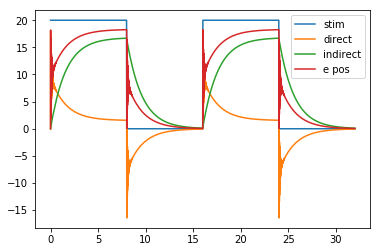

In [92]:
plt.plot(t, stim)

positions = np.array(q[2])
plt.plot(t, positions)
plt.legend(['stim','direct', 'indirect','e pos'])

## Implement AER for the network

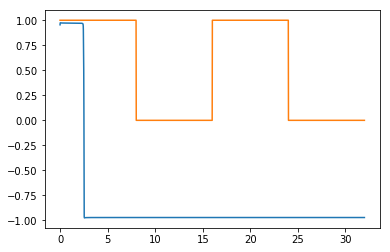

In [103]:
def activation(x):
    return np.tanh(x)

noPre = [0, 3, 2]
preIds = [0, 1, 2, 1, 2]
currents = [0.1, 0.8, 0.8]
weights = [0.0482, 0.77355, 0.5706, -0.4706, 0.891141]

def propagate():
    offset = 0
    for i, n in enumerate(noPre):
        if n is 0:
            continue
        out = 0.
        
        for index in range(offset, offset+n):
            
            out += currents[preIds[index]]*weights[index]

        currents[i] = activation(out + currents[i])
        offset += n
    
    
vn = []
for x in t:
    propagate()
    vn.append(currents[1])

plt.plot(t,vn)
plt.plot(t, stim/20)